In [1]:
import pandas as pd
import os
import numpy as np
import re
from scipy import stats
import multiprocessing

import time
import json

import spotipy
import spotipy.util as util
from tqdm import tqdm

from urllib.request import urlretrieve
import librosa
import librosa.display, librosa.feature
import warnings

import IPython.display as ipd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
data_folder = '../'
data_Echonest = 'Echonest/'
data_msd = 'MSD/'
data_features = 'MSD/features/'
data_triplets = 'main/'
data_main = 'main/'
data_meta = 'meta/'
data_librosa = 'librosa_features/'

# 1. Working with MSD dataset

## 1.1. Loading datasets

In [3]:
echo_tracks = pd.read_csv('../'+data_Echonest+'unique_tracks.txt', delimiter=r'<SEP>', header=None, engine='python')

echo_tracks.columns = ['trackID', 'songID', 'artistName', 'songTitle']

echo_tracks.head()

,trackID,songID,artistName,songTitle
0,TRMMMYQ128F932D901,SOQMMHC12AB0180CB8,Faster Pussy cat,Silent Night
1,TRMMMKD128F425225D,SOVFVAK12A8C1350D9,Karkkiautomaatti,Tanssi vaan
2,TRMMMRX128F93187D9,SOGTUKN12AB017F4F1,Hudson Mohawke,No One Could Ever
3,TRMMMCH128F425532C,SOBNYVR12A8C13558C,Yerba Brava,Si Vos Querés
4,TRMMMWA128F426B589,SOHSBXH12A8C13B0DF,Der Mystic,Tangle Of Aspens


In [12]:
print(echo_tracks.songID.unique().shape)

(1000000,)


In [34]:
train_triplets = pd.read_csv('../'+data_msd+'train_triplets.txt', sep='\t', header=None)

# Changing Column names
train_triplets.columns = ['userID', 'songID', 'counts']

train_triplets.head()

,userID,songID,counts
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1


In [13]:
print(train_triplets.songID.unique().shape)

(384546,)


## 1.2. Filtering datasets

### 1.2.1. echo_tracks dataset based on 'train_triplets'

In [22]:
# Filtering to songs that only exist in train_triplets dataset
echo_tracks = echo_tracks[echo_tracks.songID.isin(train_triplets.songID.unique())]

# Sorting based on songID
echo_tracks = echo_tracks.sort_values(by='songID')

# Resetting the index
echo_tracks = echo_tracks.reset_index(drop=True)

echo_tracks.head()

In [26]:
# Saving the resulted echo_tracks dataframe
#echo_tracks.to_csv('echo_tracks.csv', encoding='utf-8')

### 1.2.2. Filtering 'song2trackID' dataset based on 'echo_tracks'

In [33]:
# Loading the song2trackID dataframe
song2trackID = pd.read_csv('../'+'songID_to_tracks.csv', index_col=None, encoding='utf-8', low_memory=False)

print(song2trackID.shape)
song2trackID.head()

(2323112, 4)


,songID,trackID,song_title,artist_name
0,SODISJV12AF729B9CF,3WS5gHAdTLpykQ9WzkWxH0,Long Ride Home,Peter White
1,SODISJV12AF729B9CF,0kFjKTr4yrpebHlouuZRuP,Long Ride Home,Peter White
2,SODISJV12AF729B9CF,2K9bAi13m1xRMTcyei7k7u,Long Ride Home,Peter White
3,SOAHZQS1313438A42B,1yK9XBy26JHKidvTeDiMtr,Stay Away,Toto
4,SOAHZQS1313438A42B,1UO5zHCOGMd1LJB0y0QFrY,Stay Away,Toto


In [37]:
# Keeping rows of song2trackID that exists in 'echo_tracks' dataframe
song2trackID = song2trackID[song2trackID.songID.isin(echo_tracks.songID.unique())]

print(song2trackID.shape)

(499687, 4)


In [40]:
# Saving the filtered son2trackID dataframe
song2trackID.to_csv('song2trackID_f.csv', encoding='utf-8')

### 1.2.3. Filtering 'echo_tracks' again based on 'song2trackID' dataframe

In [39]:
# Filtering eco_tracks that exists in song2trackID
echo_tracks = echo_tracks[echo_tracks.songID.isin(song2trackID.songID.unique())]

print(echo_tracks.shape)

(168139, 4)


In [41]:
# Saving the filtered echo_tracks dataframe
echo_tracks.to_csv('echo_tracks_f.csv', encoding='utf-8')

In [38]:
# Filtering train_triplets that exists in song2trackID
train_triplets = train_triplets[train_triplets.songID.isin(song2trackID.songID.unique())]

print(train_triplets.shape)

(17222969, 3)


In [42]:
# Saving the filtered train_triplets dataframe
train_triplets.to_csv('train_triplets_f.csv', encoding='utf-8')

## 1.3. Using Spotify API for getting meta data and audio features

### 1.3.1. Functions

In [3]:
 
i = 5000

def getSpotifyInfo(x):
    '''
    This function gets x [Pandas groupedby object] and looks for a valid 'trackID', and then use Spotify API
    to get back the information of that specific track
    '''
    global i
    global sp
    i +=1
    if i>=5000:
        i=0
        # Getting the tocken for authentication
        token = util.prompt_for_user_token(username, scope, client_id=client_id, 
                                           client_secret=client_secret, redirect_uri='http://google.com/')

        try: # Test whether the authentication credentials are valid, if yes create Spotipy object 
            sp = spotipy.Spotify(auth=token)
            print('Spotify token has changed!!')
        except:
            raise ValueError('There is problem with Token!')
    
    # Resetting the index and making a copy of dataframe
    x = x.reset_index(drop=True).copy()
    
    # Creating the Emplty Series
    df = pd.Series(dict(songID=x.loc[0,['songID']][0], trackID=None,
                        songTitle=x.loc[0,['song_title']][0], artistName=x.loc[0,['artist_name']][0],
                        artistID=None, albumID=None,
                        popularity=None, URL=None))
    
    # Sending request to Spotify API for the list of tracks
    results = []
    tracks_list = list(x['trackID'])
    
    while tracks_list:
        try: 
            results.extend(sp.tracks(tracks=tracks_list[:50])['tracks'])
        except:
            i= 5000
            print('Error during handling results!')
            break
        tracks_list = tracks_list[50:]
    

    # Looping inside the results from Spotify API
    for js_tr in results:
        # If 'preview_url' is not Null, then use that dictionary to fill all of the requested features
        if not js_tr:
            continue
        elif  js_tr['preview_url']:
            if 'album' in js_tr:
                df['albumID'] = js_tr['album']['id']
            if 'artists' in js_tr:
                df['artistID'] = js_tr['artists'][0]['id']
                df['artistName'] = js_tr['artists'][0]['name']
            if 'name' in js_tr:
                df['songTitle'] = js_tr['name']
            if 'popularity' in js_tr:
                df['popularity'] = js_tr['popularity']
            if 'preview_url' in js_tr:
                df['URL'] = js_tr['preview_url']
            if 'id' in js_tr:
                df['trackID'] = js_tr['id']

            break
    # If it couldn't find any 'preview_url', then if will fill the requested features with the first dictionary
    if results:
        try:
            results = results[0]

            if 'album' in results:
                df['albumID'] = results['album']['id']
            if 'artists' in results:
                df['artistID'] = results['artists'][0]['id']
                df['artistName'] = results['artists'][0]['name']
            if 'name' in results:
                df['songTitle'] = results['name']
            if 'popularity' in results:
                df['popularity'] = results['popularity']
            if 'preview_url' in results:
                df['URL'] = results['preview_url']
            if 'id' in results:
                df['trackID'] = results['id']
        except:
            print('**************************************')
            print('Problem Occured in x: \n{}\n'.format(x))
            print('Results is:', results)
    time.sleep(0.02)
    
    return df
    

In [ ]:
def getAudioFeatures(track_ids):
    '''
    Gets audio features from spotify API
    
        Returns: 
            Pandas Dataframe containing all Spotify audio features and their track id
        
        Parameters:
            - track_ids: a list (or Pandas Series/Numpy array) of track IDs for finding their audio features
    '''
    
    global sp

    step_size = 50 # number of features to get in each step
    
    # Intializing features list
    danceability = []
    energy = []
    key_a = []
    loudness = []
    mode_a = []
    speechiness = []
    acousticness = []
    instrumentalness = []
    liveness = []
    valence = []
    tempo = []
    analysis_url = []
    duration_ms = []
    tr_id = []
    
    # Creating progress bar
    total = len(track_ids)
    pbar = tqdm.tqdm(total=total)
    
    # Iterating over the whole list
    while track_ids:
        try:
            au_feat = sp.audio_features(tracks=track_ids[:step_size])
        except:
            # Putting on delay
            time.sleep(30)
            
            try: # Test whether the authentication credentials are valid, if yes create Spotipy object 
                # Getting the authentication token
                token = util.prompt_for_user_token(username, scope, client_id=client_id, 
                                                   client_secret=client_secret, redirect_uri='http://google.com/')
                # Initializing Spotify object again
                sp = spotipy.Spotify(auth=token)
                # Trying to get audio features again
                au_feat = sp.audio_features(tracks=track_ids[:step_size])
            except:
                # Otherwise putting audio features as None
                au_feat = [None]
        
        for feature in au_feat:
            if feature:
                danceability.append(feature['danceability'])
                energy.append(feature['energy'])
                key_a.append(feature['key'])
                loudness.append(feature['loudness'])
                mode_a.append(feature['mode'])
                speechiness.append(feature['speechiness'])
                acousticness.append(feature['acousticness'])
                instrumentalness.append(feature['instrumentalness'])
                liveness.append(feature['liveness'])
                valence.append(feature['valence'])
                tempo.append(feature['tempo'])
                analysis_url.append(feature['analysis_url'])
                duration_ms.append(feature['duration_ms'])
                tr_id.append(feature['id']) 
            else:
                print('Problem in feature!')
        
        # Updating progress bar
        pbar.update(min(step_size, len(track_ids)))
        # Updating the list of track IDs
        track_ids = track_ids[step_size:]
    
    # Closing pbar
    pbar.close()
    
    # Creating the dataframe
    df = pd.DataFrame(dict(audio_Danceability = danceability,
                           audio_Energy = energy,
                           audio_Key = key_a,
                           audio_Loudness = loudness,
                           audio_Mode = mode_a,
                           audio_Speechiness = speechiness,
                           audio_Acousticness = acousticness,
                           audio_Instrumentalness = instrumentalness,
                           audio_Liveness = liveness,
                           audio_Valence = valence,
                           audio_Tempo = tempo,
                           audio_Duration_ms = duration_ms,
                           audio_AnalysisURL = analysis_url,
                           trackID = tr_id))
    return df

### 1.3.2. Initializing Spotify Object

In [16]:
#### Initializing Spotify Objects for the first time ####
#########################################################

# Defining Authentication credentials
scope = 'user-library-read'
username = "ikm15h7vd4p3doyz3lhqldqbj"
client_id = '48704950eccb4488b15516983ceb93b8'
client_secret = '3202e77faa33455b9874f185757baadb'

# Getting the tocken for authentication
token = util.prompt_for_user_token(username, scope, client_id=client_id , 
                                   client_secret=client_secret, redirect_uri='http://google.com/')

try: # Test whether the authentication credentials are valid, if yes create Spotipy object 
    sp = spotipy.Spotify(auth=token)
except:
    raise ValueError('There is problem with Token!')

### 1.3.3. Getting Spotify audio features

In [6]:
#######################################################################################
##### Processing 'song2trackID' data frame into chunks of 50,000 and saving back ######
#######################################################################################


# Loading song2trackID into chunks
song2trackID = pd.read_csv(data_folder+data_msd+'song2trackID_f2.csv', index_col=0, 
                           encoding='utf-8', chunksize=50000)

# Initialize counters
start_chunk = 1
counter_d = 0
i = 5000

for df in song2trackID:
    if counter_d<start_chunk:
        counter_d += 1
        continue
    print('******************************************************************')
    print('******************************************************************')
    print('Chunck {} has started!'.format(counter_d))
    display(df.head())
    print('******************************************************************')
    songs_features = df.groupby(by=['songID', 'song_title', 'artist_name'])\
                       .apply(lambda x: getSpotifyInfo(x)).reset_index(drop=True)
    # Saving the result
    f_name = "songs_features_{}.csv".format(counter_d)
    songs_features.to_csv(f_name, encoding='utf-8')
    
    print('******************************************************************')
    print('Chunk {} is finished!'.format(counter_d))
    # Changing counters values
    counter_d += 1
    i = 5000
    # Putting on delay for 
    time.sleep(120)
    

In [ ]:
#################################################################################
###### Getting Spotify audio features from chunked 'song2trackID' datasets ######
#################################################################################

start_id = 0 # the id of chunk to start


for count_au in range(start_id, 10):
    # Loading the previously made csv files containing trackIDs
    f_name = 'songs_features_{}.csv'.format(count_au)
    songsFeat_df = pd.read_csv(f_name, index_col=0, encoding='utf-8')
    
    #audio_features = pd.merge(songsFeat_df, getAudioFeatures(list(songsFeat_df.trackID)), 
    #                               how='outer', left_index=True, right_index=True)

    audio_features = getAudioFeatures(list(songsFeat_df.trackID.dropna()))

    # Saving the result
    f_name = 'audio_features_{}.csv'.format(count_au)
    audio_features.to_csv(f_name, encoding='utf-8')

    # Putting on delay
    time.sleep(15)

### 1.3.4 Loading and concatenating all songs_features datasets together

In [89]:
num_load = 10
# List of songs_features dataframe columns
list_columns = ['songID', 'trackID','songTitle','artistName','artistID', 'albumID', 'popularity', 'URL']
# Initializing empty dataframe
songs_features = pd.DataFrame(columns=list_columns)

# ITerating over the whole dataframes
for i in range(num_load):
    # Loading the dataframe
    songs_features = pd.concat([songs_features,
                                pd.read_csv(data_folder+data_msd+'songs_features_'+str(i)+'.csv', 
                                            encoding='utf-8', index_col=0)],
                               ignore_index=True, join='outer', axis=0)

# Reset index
songs_features = songs_features.reset_index(drop=True)

# Saving the resulting dataframe
songs_features.to_csv(data_folder+data_msd+'songs_features.csv', index=True, encoding='utf=8')

print(songs_features.shape)

display(songs_features.head())

(167797, 8)


,songID,trackID,songTitle,artistName,artistID,albumID,popularity,URL
0,SOAAADD12AB018A9DD,1oPJpjMvYEQJhqEDsYgHSh,The Room Of Stairs,Harold Budd,3uOCouLFR4bVx0XeiQJSbl,3jq7b66l8MswqDmi0mxzjq,11.0,https://p.scdn.co/mp3-preview/77b2e4f2d3df4851...
1,SOAAADE12A6D4F80CC,5TqXuugXB5ov1LJiXb5IAl,(I'm Gonna Start) Living Again If It Kills Me,Dave Edmunds,65Gh3BfK84aTIugiRCgLBA,0upTl2RUS4gmStWBlXjt9l,5.0,https://p.scdn.co/mp3-preview/541e7bb62eecf5c4...
2,SOAAADF12A8C13DF62,5ClMLCk8IFxkvlr5sS8PhM,KRYSAR (LIVE),LANDA DANIEL,6rSpV5hdCNJ4v1i602nj22,7uvLu2RAki7aKiASSxJPzi,15.0,https://p.scdn.co/mp3-preview/795802acaaa84ca7...
3,SOAAAFI12A6D4F9C66,6YIBHGP1MaxJsZV8ykzc07,The Less You See,I Love You But I've Chosen Darkness,15Rn3v2LgUxR0donJY8e1E,4apgpVOan95H6xvIDAfX44,3.0,https://p.scdn.co/mp3-preview/6eef762849d6bdbc...
4,SOAAAGK12AB0189572,2tBoHZ9UtMMRRljiwubtQc,Grateful,Au Revoir Simone,0X0TajZO1RmY3D8u1JymYq,0iHug1S696AsitJpyUr4T6,1.0,https://p.scdn.co/mp3-preview/35811ad304778701...


### 1.3.5. Loading and concatenating all audio_features datasets

In [92]:
num_load = 10
# List of songs_features dataframe columns
list_columns = ['audio_Danceability','audio_Energy','audio_Key','audio_Loudness','audio_Mode',
                'audio_Speechiness','audio_Acousticness','audio_Instrumentalness','audio_Liveness',
                'audio_Valence','audio_Tempo','audio_Duration_ms','audio_AnalysisURL','trackID']
# Initializing empty dataframe
audio_features = pd.DataFrame(columns=list_columns)

# ITerating over the whole dataframes
for i in range(num_load):
    # Loading the dataframe
    audio_features = pd.concat([audio_features,
                                pd.read_csv(data_folder+data_msd+'audio_features_'+str(i)+'.csv', 
                                            encoding='utf-8', index_col=0)],
                               ignore_index=True, join='outer', axis=0)

# Reset index
audio_features = audio_features.reset_index(drop=True)

# Saving the resulting dataframe
audio_features.to_csv(data_folder+data_msd+'audio_features.csv', index=True, encoding='utf=8')

print(audio_features.shape)

display(audio_features.head())

(167724, 14)


,audio_Danceability,audio_Energy,audio_Key,audio_Loudness,audio_Mode,audio_Speechiness,audio_Acousticness,audio_Instrumentalness,audio_Liveness,audio_Valence,audio_Tempo,audio_Duration_ms,audio_AnalysisURL,trackID
0,0.225,0.135,3,-26.040,0,0.0382,0.8880,0.6570,0.0510,0.0377,81.807,321133,https://api.spotify.com/v1/audio-analysis/1oPJ...,1oPJpjMvYEQJhqEDsYgHSh
1,0.509,0.347,4,-16.711,1,0.0273,0.2730,0.0328,0.2980,0.5220,102.604,199088,https://api.spotify.com/v1/audio-analysis/5TqX...,5TqXuugXB5ov1LJiXb5IAl
2,0.339,0.787,9,-6.285,0,0.0539,0.3130,0.0196,0.7100,0.4200,157.042,200880,https://api.spotify.com/v1/audio-analysis/5ClM...,5ClMLCk8IFxkvlr5sS8PhM
3,0.446,0.575,4,-6.577,0,0.0333,0.0797,0.1350,0.0963,0.4270,104.461,243533,https://api.spotify.com/v1/audio-analysis/6YIB...,6YIBHGP1MaxJsZV8ykzc07
4,0.761,0.116,6,-18.130,1,0.0357,0.6350,0.6330,0.1070,0.0589,123.054,191480,https://api.spotify.com/v1/audio-analysis/2tBo...,2tBoHZ9UtMMRRljiwubtQc


# 2. Working with MSD data

In [21]:
# loading songs_features dataset
songs_features = pd.read_csv(data_triplets+'songs_features.csv', encoding='utf-8',
                             index_col=0)

print(songs_features.shape)
songs_features.head()

(167797, 8)


,songID,trackID,songTitle,artistName,artistID,albumID,popularity,URL
0,SOAAADD12AB018A9DD,1oPJpjMvYEQJhqEDsYgHSh,The Room Of Stairs,Harold Budd,3uOCouLFR4bVx0XeiQJSbl,3jq7b66l8MswqDmi0mxzjq,11.0,https://p.scdn.co/mp3-preview/77b2e4f2d3df4851...
1,SOAAADE12A6D4F80CC,5TqXuugXB5ov1LJiXb5IAl,(I'm Gonna Start) Living Again If It Kills Me,Dave Edmunds,65Gh3BfK84aTIugiRCgLBA,0upTl2RUS4gmStWBlXjt9l,5.0,https://p.scdn.co/mp3-preview/541e7bb62eecf5c4...
2,SOAAADF12A8C13DF62,5ClMLCk8IFxkvlr5sS8PhM,KRYSAR (LIVE),LANDA DANIEL,6rSpV5hdCNJ4v1i602nj22,7uvLu2RAki7aKiASSxJPzi,15.0,https://p.scdn.co/mp3-preview/795802acaaa84ca7...
3,SOAAAFI12A6D4F9C66,6YIBHGP1MaxJsZV8ykzc07,The Less You See,I Love You But I've Chosen Darkness,15Rn3v2LgUxR0donJY8e1E,4apgpVOan95H6xvIDAfX44,3.0,https://p.scdn.co/mp3-preview/6eef762849d6bdbc...
4,SOAAAGK12AB0189572,2tBoHZ9UtMMRRljiwubtQc,Grateful,Au Revoir Simone,0X0TajZO1RmY3D8u1JymYq,0iHug1S696AsitJpyUr4T6,1.0,https://p.scdn.co/mp3-preview/35811ad304778701...


In [22]:
# Loading audio features dataset
audio_features = pd.read_csv(data_triplets+'audio_features.csv', 
                             encoding='utf-8', index_col=0)

print(audio_features.shape)
audio_features.head()

(167724, 14)


,audio_Danceability,audio_Energy,audio_Key,audio_Loudness,audio_Mode,audio_Speechiness,audio_Acousticness,audio_Instrumentalness,audio_Liveness,audio_Valence,audio_Tempo,audio_Duration_ms,audio_AnalysisURL,trackID
0,0.225,0.135,3,-26.040,0,0.0382,0.8880,0.6570,0.0510,0.0377,81.807,321133,https://api.spotify.com/v1/audio-analysis/1oPJ...,1oPJpjMvYEQJhqEDsYgHSh
1,0.509,0.347,4,-16.711,1,0.0273,0.2730,0.0328,0.2980,0.5220,102.604,199088,https://api.spotify.com/v1/audio-analysis/5TqX...,5TqXuugXB5ov1LJiXb5IAl
2,0.339,0.787,9,-6.285,0,0.0539,0.3130,0.0196,0.7100,0.4200,157.042,200880,https://api.spotify.com/v1/audio-analysis/5ClM...,5ClMLCk8IFxkvlr5sS8PhM
3,0.446,0.575,4,-6.577,0,0.0333,0.0797,0.1350,0.0963,0.4270,104.461,243533,https://api.spotify.com/v1/audio-analysis/6YIB...,6YIBHGP1MaxJsZV8ykzc07
4,0.761,0.116,6,-18.130,1,0.0357,0.6350,0.6330,0.1070,0.0589,123.054,191480,https://api.spotify.com/v1/audio-analysis/2tBo...,2tBoHZ9UtMMRRljiwubtQc


In [23]:
# loading 'echo_tracks' dataset: contains (trackID, songID, artistName, songTitle) data
echo_tracks = pd.read_csv(data_triplets+'echo_tracks_f.csv', 
                          encoding='utf-8', index_col=0)

print(echo_tracks.shape)
echo_tracks.head()

(168139, 4)


,trackID,songID,artistName,songTitle
0,TRNCENP12903C9EF3A,SOAAADD12AB018A9DD,Harold Budd,The Room Of Stairs
1,TRSKKFK128F148B615,SOAAADE12A6D4F80CC,Dave Edmunds,(I'm Gonna Start) Living Again If It Kills Me ...
2,TRCQMSP128F428A6F7,SOAAADF12A8C13DF62,LANDA DANIEL,KRYSAR (LIVE)
4,TRZEXLQ128F1491D17,SOAAAFI12A6D4F9C66,I Love You But I've Chosen Darkness,The Less You See
5,TRDZUFJ12903CE29FC,SOAAAGK12AB0189572,Au Revoir Simone,Grateful


In [24]:
# Loading 'user_profile' dataset: contains ()
user_profile = pd.read_csv(data_triplets+'train_triplets_f.csv', 
                           encoding='utf-8', index_col=0)

print(user_profile.shape)
user_profile.head()

/root/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(17222969, 3)


,userID,songID,counts
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1
6,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBSUJE12A6D4F8CF5,2
7,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBVFZR12A6D4F8AE3,1


## 2.1. Dropping tracks without URL

In [25]:
sh_0 = songs_features.shape[0]
# Dropping NA rows
songs_features = songs_features.dropna(subset=['URL']).reset_index(drop=True)

print('Number of dropped rows: {}, and number of remaining rows: {}'
      .format(sh_0-songs_features.shape[0], songs_features.shape[0]))

Number of dropped rows: 103295, and number of remaining rows: 64502


In [31]:
# saving the final 'songs_features' dataset
songs_features.to_csv(data_triplets+'songs_features_final.csv', 
                      encoding='utf-8', index=True)

### 2.1.1. Saving songs_features into chunks for getting Librosa features

In [40]:
data_librosa = 'librosa_features/'

In [43]:
# Loading 'songs_features' into chunks of 20,000 tracks
features_it = pd.read_csv(data_triplets+'songs_features_final.csv', 
                          index_col=0, encoding='utf-8', chunksize=20000)

# Saving chunks
for i, df in enumerate(features_it):
    df[['trackID', 'artistID', 'albumID', 'URL']].to_csv(data_triplets+data_librosa+'ID_url_{:02d}.csv'
                                                         .format(i), encoding='utf-8', index=False)

## 2.2. Adding trackID to user profile dataset

In [30]:
userProfile = pd.merge(user_profile, songs_features[['songID', 'trackID']], 
                         how='left', sort=False, on='songID')

print(userProfile.shape)
display(userProfile.head())

# Dropping NAs and duplicates
userProfile = userProfile.dropna(subset=['trackID'])\
                         .drop_duplicates(subset=['userID', 'songID', 'counts']).reset_index(drop=True)

print('Size of dataset after dropping NAs in trackID: {}'.format(userProfile.shape))

display(userProfile.head())

(17224163, 4)


,userID,songID,counts,trackID
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,NaN
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1,NaN
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1,NaN
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBSUJE12A6D4F8CF5,2,2ECKXkpPAxky87ohawpaeD
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBVFZR12A6D4F8AE3,1,5WjXULJvSlMxuies9diz1Q


Size of dataset after dropping NAs in trackID: (4911782, 4)


,userID,songID,counts,trackID
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBSUJE12A6D4F8CF5,2,2ECKXkpPAxky87ohawpaeD
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBVFZR12A6D4F8AE3,1,5WjXULJvSlMxuies9diz1Q
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXALG12A8C13C108,1,1bqi9YEdZweX9H6JuSQ6Qw
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOFFJPX12A6D4F7456,1,5gt7UxeqKqaZjoBPE6Nz0R
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOHQZCA12A6D4FB317,1,3858gP4ZcAJKVl5pFQpTTo


In [44]:
# Saving final 'userProfile' dataset
userProfile.to_csv(data_triplets+'userProfile_final.csv', encoding='utf-8', index=True)

# 3. Adding features and metadata

## 3.1. Handling genres from Spotify

In [102]:
# Loading genres dataset
genres_df = pd.read_csv(data_main+data_meta+'artistGenres_data.csv', low_memory=False,
                       index_col=0, encoding='utf-8')

print(genres_df.shape)
genres_df.head()

(65818, 4)


,artistID,artistName,artistFollowers,genres
0,3uOCouLFR4bVx0XeiQJSbl,Harold Budd,30414,"['ambient', 'american contemporary classical',..."
1,65Gh3BfK84aTIugiRCgLBA,Dave Edmunds,28604,"['blues-rock', 'british blues', 'power pop', '..."
2,6rSpV5hdCNJ4v1i602nj22,LANDA DANIEL,794,[]
3,15Rn3v2LgUxR0donJY8e1E,I Love You But I've Chosen Darkness,6603,['austindie']
4,0X0TajZO1RmY3D8u1JymYq,Au Revoir Simone,61008,"['brooklyn indie', 'indie pop']"


In [52]:
# Loading mapped genres list
genres_list = pd.read_csv(data_main+data_meta+'genres_list.csv', low_memory=False,
                         encoding='utf-8', nrows=100)

genres_list.head()

,genres
0,viking metal
1,candy pop
2,deep funk
3,classic arab pop
4,jungle


In [103]:
########################################################################
##### Extracting top genre and mapping them into 'selected genres' #####
########################################################################

##### Finding all distinct genres in the dataset
# defining regex pattern
pattern = r"'([^']*)'"

#genres_df['topGenre1'] = None
#genres_df['topGenre2'] = None

def returnGenre(df):
    '''
    Gets string of genres and return first and second genre
    '''
    
    # Initializing list
    topGenre1 = topGenre2 = None
    
    # gets list of genres
    g_list = re.findall(pattern, df['genres'])
    
    if g_list:
        topGenre1 = g_list[0]
        if len(g_list)>1:
            topGenre2 = g_list[1]
    
    return pd.Series(dict(topGenre1=topGenre1, topGenre2=topGenre2), name=df.name)

# getting topGenre columns
genres_df[['topGenre1', 'topGenre2']] = genres_df.apply(lambda x: returnGenre(x), axis=1)

# Save back 'genres'
genres_df.drop(columns=['genres']).to_csv(data_main+data_meta+'artistGenres_compiled.csv', 
                                          index=True, encoding='utf-8')

## 3.2. Computing Librosa features

### 3.2.1 Testing Librosa features for one of the Spotify songs

In [53]:
link = 'https://p.scdn.co/mp3-preview/fe79cac4e5f67a23d54ea5e884d86af1b5248a88?cid=48704950eccb4488b15516983ceb93b8'

filename = 'song_temp.MP3'
urlretrieve(link, filename)

ipd.Audio('song_temp.MP3')

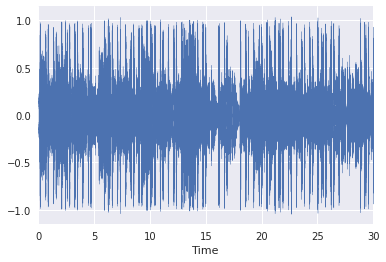

In [54]:
# Loading audio file to Librosa library
audio, sr = librosa.load(filename)

librosa.display.waveplot(audio)

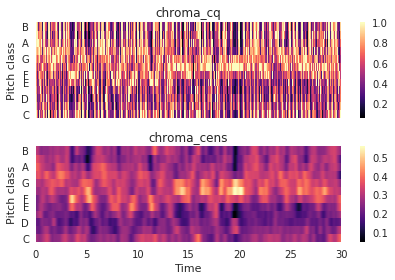

In [55]:
# Plotting 'Chroma_cens' and 'Chroma_cq' features from Librosa

chroma_cens = librosa.feature.chroma_cens(y=audio, sr=sr)
chroma_cq = librosa.feature.chroma_cqt(y=audio, sr=sr)
        
plt.figure()

plt.subplot(2,1,1)
librosa.display.specshow(chroma_cq, y_axis='chroma')
plt.title('chroma_cq')
plt.colorbar()

plt.subplot(2,1,2)
librosa.display.specshow(chroma_cens, y_axis='chroma', x_axis='time')
plt.title('chroma_cens')
plt.colorbar()

plt.tight_layout()

### 3.2.2. Functions

In [116]:
def df_columns():
    feature_sizes = dict(chroma_stft=12, chroma_cqt=12, chroma_cens=12,
                         tonnetz=6, mfcc=20, rmse=1, zcr=1,
                         spectral_centroid=1, spectral_bandwidth=1,
                         spectral_contrast=7, spectral_rolloff=1)
    moments = ('mean', 'std', 'skew', 'kurtosis', 'median', 'min', 'max')

    columns = []
    for name, size in feature_sizes.items():
        for moment in moments:
            it = ((name, moment, '{:02d}'.format(i+1)) for i in range(size))
            columns.extend(it)

    names = ('feature', 'statistics', 'number')
    columns = pd.MultiIndex.from_tuples(columns, names=names)

    # More efficient to slice if indexes are sorted.
    return columns.sort_values()


def compute_features(tid):
    #global trackUrl_df
    
    features = pd.Series(index=df_columns(), dtype=np.float32, name=tid)

    # Catch warnings as exceptions (audioread leaks file descriptors).
    warnings.filterwarnings('error', module='librosa')

    def feature_stats(name, values):
        features[name, 'mean'] = np.mean(values, axis=1)
        features[name, 'std'] = np.std(values, axis=1)
        features[name, 'skew'] = stats.skew(values, axis=1)
        features[name, 'kurtosis'] = stats.kurtosis(values, axis=1)
        features[name, 'median'] = np.median(values, axis=1)
        features[name, 'min'] = np.min(values, axis=1)
        features[name, 'max'] = np.max(values, axis=1)

    try:
        # Defining temporary filepath
        filepath = 'song_{}'.format(tid)
        # Retrieving the audio file and storing it
        urlretrieve(trackUrl_df.loc[tid], filepath)
        # Loading audio file in Librosa
        x, sr = librosa.load(filepath, sr=None, mono=True)  # kaiser_fast
        
        # Computing Zero_Crossing_Rate feature
        f = librosa.feature.zero_crossing_rate(x, frame_length=2048, hop_length=512)
        feature_stats('zcr', f)
        
        # Computing Chroma_CQT feature
        cqt = np.abs(librosa.cqt(x, sr=sr, hop_length=512, bins_per_octave=12,
                                 n_bins=7*12, tuning=None))
        assert cqt.shape[0] == 7 * 12
        assert np.ceil(len(x)/512) <= cqt.shape[1] <= np.ceil(len(x)/512)+1

        f = librosa.feature.chroma_cqt(C=cqt, n_chroma=12, n_octaves=7)
        feature_stats('chroma_cqt', f)
        
        # Computing Chroma_Cens feature
        f = librosa.feature.chroma_cens(C=cqt, n_chroma=12, n_octaves=7)
        feature_stats('chroma_cens', f)
        
        # Computing Tonnetz feature
        f = librosa.feature.tonnetz(chroma=f)
        feature_stats('tonnetz', f)

        del cqt
        stft = np.abs(librosa.stft(x, n_fft=2048, hop_length=512))
        assert stft.shape[0] == 1 + 2048 // 2
        assert np.ceil(len(x)/512) <= stft.shape[1] <= np.ceil(len(x)/512)+1
        del x
        
        # Computing Chroma_stft feature
        f = librosa.feature.chroma_stft(S=stft**2, n_chroma=12)
        feature_stats('chroma_stft', f)
        
        # Computing RMSE feature
        f = librosa.feature.rmse(S=stft)
        feature_stats('rmse', f)
        # Computing Spectral_Centroid feature
        f = librosa.feature.spectral_centroid(S=stft)
        feature_stats('spectral_centroid', f)
        # Computing Spectral_Bandwidth feature
        f = librosa.feature.spectral_bandwidth(S=stft)
        feature_stats('spectral_bandwidth', f)
        # Computing Spectral_Contrast feature
        f = librosa.feature.spectral_contrast(S=stft, n_bands=6)
        feature_stats('spectral_contrast', f)
        # Computing Spectral_RollOff feature
        f = librosa.feature.spectral_rolloff(S=stft)
        feature_stats('spectral_rolloff', f)
        # Computing MFCC feature
        mel = librosa.feature.melspectrogram(sr=sr, S=stft**2)
        del stft
        f = librosa.feature.mfcc(S=librosa.power_to_db(mel), n_mfcc=20)
        feature_stats('mfcc', f)
        # Removing temporary file
        os.remove(filepath)

    except Exception as e:
        print('{}: {}'.format(tid, repr(e)))

    return features

In [ ]:
################################################################
#### Starting Calculating the Audio features using Librosa! ####
################################################################

# For multi-processing: More than usable CPUs to be CPU bound, not I/O bound. Beware memory.
nb_workers = int(2 * len(os.sched_getaffinity(0)))
print('Working with {} processes.'.format(nb_workers))

# Initializing iteration values
start_chunk = 0
num_chunk = 4

# Iterating over specified chunks and saving the resulting dataframes
for chunk in range(start_chunk, num_chunk):
    
    print('features_{} has started!'.format(chunk))
    
    # Load 'trackUrl' dataframe
    trackUrl_df = pd.read_csv('{}{}ID_url_{:02d}.csv'.format(data_main,data_librosa, chunk),
                             index_col=None, encoding='utf-8')
    
    # Setting index
    trackUrl_df = trackUrl_df.set_index('trackID')['URL']
    
    # Getting trackIDs
    tids = trackUrl_df.index.values

    # Initializing empty 'features' dataframe
    features = pd.DataFrame(index=tids, columns=df_columns(), dtype=np.float32)

    # Initializing multi-processing
    pool = multiprocessing.Pool(nb_workers)
    it = pool.imap_unordered(compute_features, tids)
    

    for i, row in enumerate(tqdm(it, total=len(tids))):
        features.loc[row.name, :] = row

    # Saving the resulting 'features' dataframe
    features.to_csv('{}{}librosa_features_{:02d}.csv'.format(data_main,data_librosa, chunk), 
                    index=True, header=True, encoding='utf-8')


# 3. Preparing meta datasets

## 3.1. Adding date

In [158]:
# Loading 'tracks' dataset
tracks = pd.read_csv(data_main+'songs_features_final.csv', 
                        index_col=0, encoding='utf-8', low_memory=False)
print('Shape before dropping duplicates: {}'.format(tracks.shape))
# Dropping duplicates
tracks = tracks.drop_duplicates(subset=['songID'])

print(tracks.shape)
tracks.head()

Shape before dropping duplicates: (64502, 8)
(64500, 8)


,songID,trackID,songTitle,artistName,artistID,albumID,popularity,URL
0,SOAAADD12AB018A9DD,1oPJpjMvYEQJhqEDsYgHSh,The Room Of Stairs,Harold Budd,3uOCouLFR4bVx0XeiQJSbl,3jq7b66l8MswqDmi0mxzjq,11.0,https://p.scdn.co/mp3-preview/77b2e4f2d3df4851...
1,SOAAADE12A6D4F80CC,5TqXuugXB5ov1LJiXb5IAl,(I'm Gonna Start) Living Again If It Kills Me,Dave Edmunds,65Gh3BfK84aTIugiRCgLBA,0upTl2RUS4gmStWBlXjt9l,5.0,https://p.scdn.co/mp3-preview/541e7bb62eecf5c4...
2,SOAAADF12A8C13DF62,5ClMLCk8IFxkvlr5sS8PhM,KRYSAR (LIVE),LANDA DANIEL,6rSpV5hdCNJ4v1i602nj22,7uvLu2RAki7aKiASSxJPzi,15.0,https://p.scdn.co/mp3-preview/795802acaaa84ca7...
3,SOAAAFI12A6D4F9C66,6YIBHGP1MaxJsZV8ykzc07,The Less You See,I Love You But I've Chosen Darkness,15Rn3v2LgUxR0donJY8e1E,4apgpVOan95H6xvIDAfX44,3.0,https://p.scdn.co/mp3-preview/6eef762849d6bdbc...
4,SOAAAGK12AB0189572,2tBoHZ9UtMMRRljiwubtQc,Grateful,Au Revoir Simone,0X0TajZO1RmY3D8u1JymYq,0iHug1S696AsitJpyUr4T6,1.0,https://p.scdn.co/mp3-preview/35811ad304778701...


In [159]:
# Loading 'genres' dataset
dates_df = pd.read_csv(data_main+data_meta+'album_dates.csv', 
                        index_col=0, encoding='utf-8', low_memory=False)

print('Shape before dropping duplicates: {}'.format(dates_df.shape))
# Dropping duplicates
dates_df = dates_df.fillna(0).drop_duplicates(subset=['albumID'])

print(dates_df.shape)
dates_df.head()

Shape before dropping duplicates: (32036, 2)
(30435, 2)


,albumID,releaseDate
0,3jq7b66l8MswqDmi0mxzjq,2000
1,0upTl2RUS4gmStWBlXjt9l,1981
2,7uvLu2RAki7aKiASSxJPzi,2003
3,4apgpVOan95H6xvIDAfX44,2003
4,0iHug1S696AsitJpyUr4T6,2009


In [160]:
# Adding album date to 'tracks' dataframe
tracks = pd.merge(tracks, dates_df, how='left', sort=False, on='albumID')

# changing dtype
tracks.releaseDate = tracks.releaseDate.fillna(0).astype(np.int16)

print('Shape before dropping duplicates: {}'.format(tracks.shape))
# Dropping duplicates
tracks = tracks.drop_duplicates(subset=['songID'])

print(tracks.shape)
tracks.head()

Shape before dropping duplicates: (64500, 9)
(64500, 9)


,songID,trackID,songTitle,artistName,artistID,albumID,popularity,URL,releaseDate
0,SOAAADD12AB018A9DD,1oPJpjMvYEQJhqEDsYgHSh,The Room Of Stairs,Harold Budd,3uOCouLFR4bVx0XeiQJSbl,3jq7b66l8MswqDmi0mxzjq,11.0,https://p.scdn.co/mp3-preview/77b2e4f2d3df4851...,2000
1,SOAAADE12A6D4F80CC,5TqXuugXB5ov1LJiXb5IAl,(I'm Gonna Start) Living Again If It Kills Me,Dave Edmunds,65Gh3BfK84aTIugiRCgLBA,0upTl2RUS4gmStWBlXjt9l,5.0,https://p.scdn.co/mp3-preview/541e7bb62eecf5c4...,1981
2,SOAAADF12A8C13DF62,5ClMLCk8IFxkvlr5sS8PhM,KRYSAR (LIVE),LANDA DANIEL,6rSpV5hdCNJ4v1i602nj22,7uvLu2RAki7aKiASSxJPzi,15.0,https://p.scdn.co/mp3-preview/795802acaaa84ca7...,2003
3,SOAAAFI12A6D4F9C66,6YIBHGP1MaxJsZV8ykzc07,The Less You See,I Love You But I've Chosen Darkness,15Rn3v2LgUxR0donJY8e1E,4apgpVOan95H6xvIDAfX44,3.0,https://p.scdn.co/mp3-preview/6eef762849d6bdbc...,2003
4,SOAAAGK12AB0189572,2tBoHZ9UtMMRRljiwubtQc,Grateful,Au Revoir Simone,0X0TajZO1RmY3D8u1JymYq,0iHug1S696AsitJpyUr4T6,1.0,https://p.scdn.co/mp3-preview/35811ad304778701...,2009


## 3.2. Adding Genre and Artist's followers

In [161]:
# Loading 'genres' dataset
genres = pd.read_csv(data_main+data_meta+'artistGenres_compiled.csv', 
                        index_col=0, encoding='utf-8', low_memory=False)

print('Shape before dropping duplicates: {}'.format(genres.shape))
# Dropping NAs and duplicates
genres = genres.dropna(subset=['topGenre1']).drop_duplicates(subset=['artistID'])\
               .reset_index(drop=True)

print(genres.shape)
genres.head()

Shape before dropping duplicates: (65818, 5)
(11265, 5)


,artistID,artistName,artistFollowers,topGenre1,topGenre2
0,3uOCouLFR4bVx0XeiQJSbl,Harold Budd,30414,ambient,american contemporary classical
1,65Gh3BfK84aTIugiRCgLBA,Dave Edmunds,28604,blues-rock,british blues
2,15Rn3v2LgUxR0donJY8e1E,I Love You But I've Chosen Darkness,6603,austindie,NaN
3,0X0TajZO1RmY3D8u1JymYq,Au Revoir Simone,61008,brooklyn indie,indie pop
4,11v210K5CwGkgbGK3COISh,Ingmar Nordströms,4266,dansband,NaN


In [162]:
# Adding album date to 'tracks' dataframe
col_sel = ['artistID', 'artistFollowers', 'topGenre1', 'topGenre2']

tracks = pd.merge(tracks, genres[col_sel], how='left', sort=False, on='artistID')

print(tracks.shape)
tracks.head()

(64500, 12)


,songID,trackID,songTitle,artistName,artistID,albumID,popularity,URL,releaseDate,artistFollowers,topGenre1,topGenre2
0,SOAAADD12AB018A9DD,1oPJpjMvYEQJhqEDsYgHSh,The Room Of Stairs,Harold Budd,3uOCouLFR4bVx0XeiQJSbl,3jq7b66l8MswqDmi0mxzjq,11.0,https://p.scdn.co/mp3-preview/77b2e4f2d3df4851...,2000,30414.0,ambient,american contemporary classical
1,SOAAADE12A6D4F80CC,5TqXuugXB5ov1LJiXb5IAl,(I'm Gonna Start) Living Again If It Kills Me,Dave Edmunds,65Gh3BfK84aTIugiRCgLBA,0upTl2RUS4gmStWBlXjt9l,5.0,https://p.scdn.co/mp3-preview/541e7bb62eecf5c4...,1981,28604.0,blues-rock,british blues
2,SOAAADF12A8C13DF62,5ClMLCk8IFxkvlr5sS8PhM,KRYSAR (LIVE),LANDA DANIEL,6rSpV5hdCNJ4v1i602nj22,7uvLu2RAki7aKiASSxJPzi,15.0,https://p.scdn.co/mp3-preview/795802acaaa84ca7...,2003,NaN,NaN,NaN
3,SOAAAFI12A6D4F9C66,6YIBHGP1MaxJsZV8ykzc07,The Less You See,I Love You But I've Chosen Darkness,15Rn3v2LgUxR0donJY8e1E,4apgpVOan95H6xvIDAfX44,3.0,https://p.scdn.co/mp3-preview/6eef762849d6bdbc...,2003,6603.0,austindie,NaN
4,SOAAAGK12AB0189572,2tBoHZ9UtMMRRljiwubtQc,Grateful,Au Revoir Simone,0X0TajZO1RmY3D8u1JymYq,0iHug1S696AsitJpyUr4T6,1.0,https://p.scdn.co/mp3-preview/35811ad304778701...,2009,61008.0,brooklyn indie,indie pop


## 3.3. Handling columns and save

In [163]:
# Changing columns names
tracks = tracks.rename(columns={'popularity': 'trackPopularity', 'songTitle':'trackTitle'})

In [164]:
# Dropping unnecessary columns
tracks = tracks.drop(columns=['URL'])

# Changin orders of columns
col_or = ['trackID', 'trackTitle', 'artistName', 'trackPopularity', 
          'releaseDate', 'artistFollowers', 'topGenre1', 'topGenre2',
          'artistID', 'albumID', 'songID']
tracks = tracks[col_or]

tracks.head()

,trackID,trackTitle,artistName,trackPopularity,releaseDate,artistFollowers,topGenre1,topGenre2,artistID,albumID,songID
0,1oPJpjMvYEQJhqEDsYgHSh,The Room Of Stairs,Harold Budd,11.0,2000,30414.0,ambient,american contemporary classical,3uOCouLFR4bVx0XeiQJSbl,3jq7b66l8MswqDmi0mxzjq,SOAAADD12AB018A9DD
1,5TqXuugXB5ov1LJiXb5IAl,(I'm Gonna Start) Living Again If It Kills Me,Dave Edmunds,5.0,1981,28604.0,blues-rock,british blues,65Gh3BfK84aTIugiRCgLBA,0upTl2RUS4gmStWBlXjt9l,SOAAADE12A6D4F80CC
2,5ClMLCk8IFxkvlr5sS8PhM,KRYSAR (LIVE),LANDA DANIEL,15.0,2003,NaN,NaN,NaN,6rSpV5hdCNJ4v1i602nj22,7uvLu2RAki7aKiASSxJPzi,SOAAADF12A8C13DF62
3,6YIBHGP1MaxJsZV8ykzc07,The Less You See,I Love You But I've Chosen Darkness,3.0,2003,6603.0,austindie,NaN,15Rn3v2LgUxR0donJY8e1E,4apgpVOan95H6xvIDAfX44,SOAAAFI12A6D4F9C66
4,2tBoHZ9UtMMRRljiwubtQc,Grateful,Au Revoir Simone,1.0,2009,61008.0,brooklyn indie,indie pop,0X0TajZO1RmY3D8u1JymYq,0iHug1S696AsitJpyUr4T6,SOAAAGK12AB0189572


## 3.4. Adding Spotify Features

In [165]:
# Loading audio features dataset
audio_features = pd.read_csv(data_main+'audio_features.csv', 
                             encoding='utf-8', index_col=0)
print('Shape before dropping duplicates: {}'.format(audio_features.shape))
# Dropping NAs and duplicates
col_dr = ['audio_Danceability','audio_Energy','audio_Key','audio_Loudness','audio_Mode',
          'audio_Speechiness','audio_Acousticness','audio_Instrumentalness','audio_Liveness',
          'audio_Valence','audio_Tempo']
audio_features = audio_features.dropna(subset=col_dr).drop_duplicates(subset=['trackID'])
print(audio_features.shape)
audio_features.head()

Shape before dropping duplicates: (167724, 14)
(167724, 14)


,audio_Danceability,audio_Energy,audio_Key,audio_Loudness,audio_Mode,audio_Speechiness,audio_Acousticness,audio_Instrumentalness,audio_Liveness,audio_Valence,audio_Tempo,audio_Duration_ms,audio_AnalysisURL,trackID
0,0.225,0.135,3,-26.040,0,0.0382,0.8880,0.6570,0.0510,0.0377,81.807,321133,https://api.spotify.com/v1/audio-analysis/1oPJ...,1oPJpjMvYEQJhqEDsYgHSh
1,0.509,0.347,4,-16.711,1,0.0273,0.2730,0.0328,0.2980,0.5220,102.604,199088,https://api.spotify.com/v1/audio-analysis/5TqX...,5TqXuugXB5ov1LJiXb5IAl
2,0.339,0.787,9,-6.285,0,0.0539,0.3130,0.0196,0.7100,0.4200,157.042,200880,https://api.spotify.com/v1/audio-analysis/5ClM...,5ClMLCk8IFxkvlr5sS8PhM
3,0.446,0.575,4,-6.577,0,0.0333,0.0797,0.1350,0.0963,0.4270,104.461,243533,https://api.spotify.com/v1/audio-analysis/6YIB...,6YIBHGP1MaxJsZV8ykzc07
4,0.761,0.116,6,-18.130,1,0.0357,0.6350,0.6330,0.1070,0.0589,123.054,191480,https://api.spotify.com/v1/audio-analysis/2tBo...,2tBoHZ9UtMMRRljiwubtQc


In [166]:
# Dropping unnecessary columns
audio_features = audio_features.drop(columns=['audio_AnalysisURL'])
# Changing columns order
col_or = ['trackID', 'audio_Duration_ms', 'audio_Danceability', 'audio_Energy',
          'audio_Key','audio_Loudness','audio_Mode','audio_Speechiness','audio_Acousticness',
          'audio_Instrumentalness','audio_Liveness','audio_Valence','audio_Tempo']
audio_features = audio_features[col_or]

# Saving dropped version
audio_features.drop(columns=['audio_Duration_ms']).to_csv(data_main+'audio_features_final.csv', 
                                                          encoding='utf-8', index=True)

audio_features.head()

,trackID,audio_Duration_ms,audio_Danceability,audio_Energy,audio_Key,audio_Loudness,audio_Mode,audio_Speechiness,audio_Acousticness,audio_Instrumentalness,audio_Liveness,audio_Valence,audio_Tempo
0,1oPJpjMvYEQJhqEDsYgHSh,321133,0.225,0.135,3,-26.040,0,0.0382,0.8880,0.6570,0.0510,0.0377,81.807
1,5TqXuugXB5ov1LJiXb5IAl,199088,0.509,0.347,4,-16.711,1,0.0273,0.2730,0.0328,0.2980,0.5220,102.604
2,5ClMLCk8IFxkvlr5sS8PhM,200880,0.339,0.787,9,-6.285,0,0.0539,0.3130,0.0196,0.7100,0.4200,157.042
3,6YIBHGP1MaxJsZV8ykzc07,243533,0.446,0.575,4,-6.577,0,0.0333,0.0797,0.1350,0.0963,0.4270,104.461
4,2tBoHZ9UtMMRRljiwubtQc,191480,0.761,0.116,6,-18.130,1,0.0357,0.6350,0.6330,0.1070,0.0589,123.054


In [167]:
# Merging audio_features with 'tracks' dataframe
tracks = pd.merge(tracks, audio_features[['trackID', 'audio_Duration_ms']], 
                  how='left', sort=False, on='trackID')

print(tracks.shape)
tracks.head()

(64500, 12)


,trackID,trackTitle,artistName,trackPopularity,releaseDate,artistFollowers,topGenre1,topGenre2,artistID,albumID,songID,audio_Duration_ms
0,1oPJpjMvYEQJhqEDsYgHSh,The Room Of Stairs,Harold Budd,11.0,2000,30414.0,ambient,american contemporary classical,3uOCouLFR4bVx0XeiQJSbl,3jq7b66l8MswqDmi0mxzjq,SOAAADD12AB018A9DD,321133
1,5TqXuugXB5ov1LJiXb5IAl,(I'm Gonna Start) Living Again If It Kills Me,Dave Edmunds,5.0,1981,28604.0,blues-rock,british blues,65Gh3BfK84aTIugiRCgLBA,0upTl2RUS4gmStWBlXjt9l,SOAAADE12A6D4F80CC,199088
2,5ClMLCk8IFxkvlr5sS8PhM,KRYSAR (LIVE),LANDA DANIEL,15.0,2003,NaN,NaN,NaN,6rSpV5hdCNJ4v1i602nj22,7uvLu2RAki7aKiASSxJPzi,SOAAADF12A8C13DF62,200880
3,6YIBHGP1MaxJsZV8ykzc07,The Less You See,I Love You But I've Chosen Darkness,3.0,2003,6603.0,austindie,NaN,15Rn3v2LgUxR0donJY8e1E,4apgpVOan95H6xvIDAfX44,SOAAAFI12A6D4F9C66,243533
4,2tBoHZ9UtMMRRljiwubtQc,Grateful,Au Revoir Simone,1.0,2009,61008.0,brooklyn indie,indie pop,0X0TajZO1RmY3D8u1JymYq,0iHug1S696AsitJpyUr4T6,SOAAAGK12AB0189572,191480


In [168]:
# Resetting index
tracks = tracks.reset_index(drop=True)

# Saving tracks
tracks.to_csv(data_main+'tracks_final.csv', encoding='utf-8', index=True)

In [169]:
# Splitting into 'small' and 'medium'
subset_ratio = 0.2
tot_num =len(tracks)
small_idx = np.random.choice(tot_num,int(subset_ratio*tot_num),replace=False)
small_idx.sort()

tracks['set_subset'] = None
tracks.loc[small_idx, 'set_subset'] = 'small'
tracks.loc[tracks.set_subset!='small', 'set_subset'] = 'medium'

# Splitting into 'train', 'test' subsets
test_ratio = 0.25
tot_num =len(tracks)
test_idx = np.random.choice(tot_num,int(test_ratio*tot_num), replace=False)
test_idx.sort()

tracks['set_split'] = None
tracks.loc[test_idx, 'set_split'] = 'test'
tracks.loc[tracks.set_split!='test', 'set_split'] = 'train'

tracks.head()

,trackID,trackTitle,artistName,trackPopularity,releaseDate,artistFollowers,topGenre1,topGenre2,artistID,albumID,songID,audio_Duration_ms,set_subset,set_split
0,1oPJpjMvYEQJhqEDsYgHSh,The Room Of Stairs,Harold Budd,11.0,2000,30414.0,ambient,american contemporary classical,3uOCouLFR4bVx0XeiQJSbl,3jq7b66l8MswqDmi0mxzjq,SOAAADD12AB018A9DD,321133,medium,train
1,5TqXuugXB5ov1LJiXb5IAl,(I'm Gonna Start) Living Again If It Kills Me,Dave Edmunds,5.0,1981,28604.0,blues-rock,british blues,65Gh3BfK84aTIugiRCgLBA,0upTl2RUS4gmStWBlXjt9l,SOAAADE12A6D4F80CC,199088,medium,train
2,5ClMLCk8IFxkvlr5sS8PhM,KRYSAR (LIVE),LANDA DANIEL,15.0,2003,NaN,NaN,NaN,6rSpV5hdCNJ4v1i602nj22,7uvLu2RAki7aKiASSxJPzi,SOAAADF12A8C13DF62,200880,medium,train
3,6YIBHGP1MaxJsZV8ykzc07,The Less You See,I Love You But I've Chosen Darkness,3.0,2003,6603.0,austindie,NaN,15Rn3v2LgUxR0donJY8e1E,4apgpVOan95H6xvIDAfX44,SOAAAFI12A6D4F9C66,243533,medium,train
4,2tBoHZ9UtMMRRljiwubtQc,Grateful,Au Revoir Simone,1.0,2009,61008.0,brooklyn indie,indie pop,0X0TajZO1RmY3D8u1JymYq,0iHug1S696AsitJpyUr4T6,SOAAAGK12AB0189572,191480,medium,train


In [170]:
test_ratio_small = tracks[(tracks.set_split=='test')&(tracks.set_subset=='small')].shape[0]\
                   /tracks[tracks.set_subset=='small'].shape[0]
print('Ratio of test to whole datapoints in "Small" subset is {:.01%}'.format(test_ratio_small))

Ratio of test to whole datapoints in "Small" subset is 25.1%


In [171]:
# Saving tracks
tracks.to_csv(data_main+'tracks_final.csv', encoding='utf-8', index=True)

# 4. Preparing features dataset

In [130]:
'{}{}librosa_features_{:02d}'.format(data_main,data_librosa,i)

'main/librosa_features/librosa_features_00'

In [150]:
i =0
df = pd.read_csv('{}{}librosa_features_{:02d}.csv'.format(data_main,data_librosa,i),
            low_memory=False, header=[0,1,2], index_col=0, nrows=5)

In [155]:
num = 4

# Initializing empty dataset
features = pd.DataFrame(columns=df_columns())

for i in range(num):
    # reading librosa features csv
    features = pd.concat([features, pd.read_csv('{}{}librosa_features_{:02d}.csv'
                                                .format(data_main,data_librosa,i),
                                                low_memory=False, header=[0,1,2], 
                                                index_col=0)], 
                         axis=0, ignore_index=False)

print(features.shape)
features.head()

(64502, 518)


feature                chroma_cens                                          \
statistics                kurtosis                                           
number                          01        02        03        04        05   
1oPJpjMvYEQJhqEDsYgHSh    0.720673  4.240027 -0.618995  0.426698 -0.226265   
5TqXuugXB5ov1LJiXb5IAl   -0.370662 -0.287299  1.182948 -0.952800 -0.790715   
5ClMLCk8IFxkvlr5sS8PhM   -0.769198 -0.571088 -0.860308  0.437645 -1.027899   
6YIBHGP1MaxJsZV8ykzc07   -0.753448 -1.368506  0.069830 -1.377341 -1.481008   
2tBoHZ9UtMMRRljiwubtQc   -0.658771 -0.948498 -0.722471 -0.713111 -0.609005   

feature                                                                   \
statistics                                                                 
number                        06        07        08        09        10   
1oPJpjMvYEQJhqEDsYgHSh -0.209698 -0.317341 -1.345874 -0.586116 -0.931247   
5TqXuugXB5ov1LJiXb5IAl -0.504890 -0.491160  0.696574  0.054538  0.780068   
5ClMLCk8IFxkvlr5sS8PhM  1.226321 -0.928717  1.680385 -1.276514 -0.994085   
6YIBHGP1MaxJsZV8ykzc07 -0.969172 -0.714859 -0.784415  0.558222 -0.925268   
2tBoHZ9UtMMRRljiwubtQc -0.417112 -1.029030  1.121774  0.314120 -1.189146   

feature                   ...      tonnetz                            zcr  \
statistics                ...          std                       kurtosis   
number                    ...           04        05        06         01   
1oPJpjMvYEQJhqEDsYgHSh    ...     0.084099  0.017905  0.017880   3.022421   
5TqXuugXB5ov1LJiXb5IAl    ...     0.127805  0.020186  0.023055  13.629067   
5ClMLCk8IFxkvlr5sS8PhM    ...     0.084305  0.018808  0.020520  10.252457   
6YIBHGP1MaxJsZV8ykzc07    ...     0.087981  0.018738  0.026488   5.244253   
2tBoHZ9UtMMRRljiwubtQc    ...     0.128777  0.034797  0.031165  12.074792   

feature                                                                   \
statistics                   max      mean    median       min      skew   
number                        01        01        01        01        01   
1oPJpjMvYEQJhqEDsYgHSh  0.400879  0.093924  0.078125  0.030273  1.610670   
5TqXuugXB5ov1LJiXb5IAl  0.286621  0.046816  0.042969  0.008301  2.550661   
5ClMLCk8IFxkvlr5sS8PhM  0.222168  0.053373  0.049316  0.013184  2.536385   
6YIBHGP1MaxJsZV8ykzc07  0.148438  0.048348  0.044922  0.017578  1.739271   
2tBoHZ9UtMMRRljiwubtQc  0.236328  0.022920  0.013184  0.002441  3.254108   

feature                           
statistics                   std  
number                        01  
1oPJpjMvYEQJhqEDsYgHSh  0.054095  
5TqXuugXB5ov1LJiXb5IAl  0.024498  
5ClMLCk8IFxkvlr5sS8PhM  0.023678  
6YIBHGP1MaxJsZV8ykzc07  0.016109  
2tBoHZ9UtMMRRljiwubtQc  0.028403  

[5 rows x 518 columns]

In [157]:
# Saving the resulting concatenated dataframe
features.to_csv(data_main+'features.csv', index=True, encoding='utf-8')